In [3]:
import itertools
import gc
from bib import *
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras import backend as K 
from keras import  activations
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Dense, Activation, regularizers,BatchNormalization,Dropout
import tensorflow as tf
from  tqdm import tqdm_notebook
tf.logging.set_verbosity(tf.logging.ERROR)

In [4]:
eps=np.finfo(np.float32).eps
xtrains,ytrains,xvals,yvals,xtest,ytest=split(('CHL 1','THERM 1','SSH','SR','WS','5days','longitude','latitude'),
                                               ['CHL '+ str(i) for i in range(2,19)])
ytrains,yvals,ytest=applyToy(lambda x:np.log(x)/np.log(10),ytrains,yvals,ytest)

In [5]:
for xt,xv in zip(xtrains,xvals):
    xt['cosT']=np.cos(np.pi*2*xt['5days']/73)
    xt['sinT']=np.sin(np.pi*2*xt['5days']/73)
    xv['cosT']=np.cos(np.pi*2*xv['5days']/73)
    xv['sinT']=np.sin(np.pi*2*xv['5days']/73)
    
    
    xt['t.5d']=xt['THERM 1']*xt['5days']
    xv['t.5d']=xv['THERM 1']*xv['5days']
    xt['t.5d']=xt['THERM 1']*xt['latitude']
    xv['t.5d']=xv['THERM 1']*xv['latitude']
    
    
    xt.drop('5days', 1,inplace=True)
    xv.drop('5days', 1,inplace=True)

    
    
    
xtest['cosT']=np.cos(np.pi*2*xtest['5days']/73)
xtest['sinT']=np.sin(np.pi*2*xtest['5days']/73)
xtest.drop('5days', 1,inplace=True)

In [6]:

def generate(arch,act):
    layers=[]
    for index,size in enumerate(arch):
        if index ==0:
            layers.append(Dense(size, input_shape=(10,),activation=act[index]))
#             layers.append(BatchNormalization())

        else:
            layers.append(Dense(size,activation=act[index]))
#             layers.append(Dropout(0.3))
    layers.append(Dense(17,activation='linear',kernel_regularizer=regularizers.l2(0.01)))
    model = Sequential(layers)
    model.compile(optimizer='Adam',
              loss='mse')
    return model
callbacks = [EarlyStopping(monitor='val_loss', patience=15)]

In [7]:
def validate(arch,act,xtrains,ytrains,xvals,yvals):
    fold_evaluation=[]
    for xt,yt,xv,yv in tqdm_notebook(zip(xtrains,ytrains,xvals,yvals),total=len(xtrains)):
        model=generate(arch,act)
        
        mean=xt.mean()
        std=xt.std()
        
        xt=(xt-mean)/std
        xv=(xv-mean)/std
        
        
#         yt=np.exp(yt*np.log(10))-eps
#         yv=np.exp(yv*np.log(10))-eps
        
        
        model.fit(xt.values,yt.values,
                  epochs=10000,
                  callbacks=callbacks,
                  verbose=0,
                  batch_size=73*10, 
                  validation_data=(xv.values,yv.values))
        
        yp = model.predict(xv.values)
        
        #check error in original space
        
        yp=np.exp(yp*np.log(10))
        yv=np.exp(yv*np.log(10))       
        fold_evaluation.append(evaluate(yp,yv))
        print(evaluate(yp,yv))
        
    return np.mean(fold_evaluation),np.std(fold_evaluation )


In [9]:
arch=(1000, 500, 500, 500, 1000, 2000)
K.clear_session()
print('ARCH :'+ str(arch)) 
# print('ACT :'+ str(act))
error,std=validate(arch,['softplus']*len(arch),xtrains,ytrains,xvals,yvals)
print('\t error: %.5f +- %.5f' % (error,std))

ARCH :(1000, 500, 500, 500, 1000, 2000)


KeyboardInterrupt: 

cos+sin 5days
ARCH :(1000, 500, 500, 500, 1000, 2000)
    error: 0.05983 +- 0.02043
ARCH :(1000, 500, 500, 500, 1000, 2000)
    error: 0.05957 +- 0.01907
cos+sin 5days + year
ARCH :(1000, 500, 500, 500, 1000, 2000)
     error: 0.05895 +- 0.01805
	 error: 0.05697 +- 0.01715
cos+sin 5days + year+ space
ARCH :(1000, 500, 500, 500, 1000, 2000)
      error: 0.05603 +- 0.01869
      
cos+sin 5days +space
ARCH :(1000, 500, 500, 500, 1000, 2000)
     error: 0.05930 +- 0.01841
cos+sin 5days + atitude no ws     
     error: 0.05950 +- 0.01988

+ vars
error: 0.05868 +- 0.02006
error: 0.05727 +- 0.01928
error: 0.05957 +- 0.01962

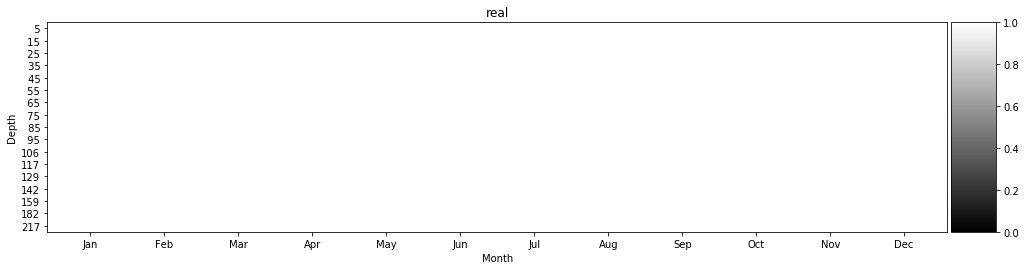

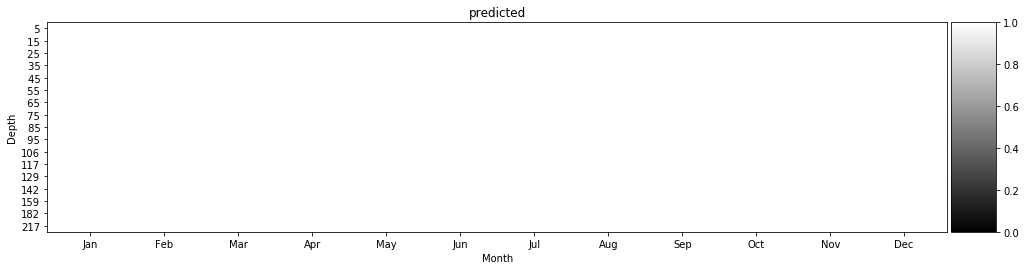

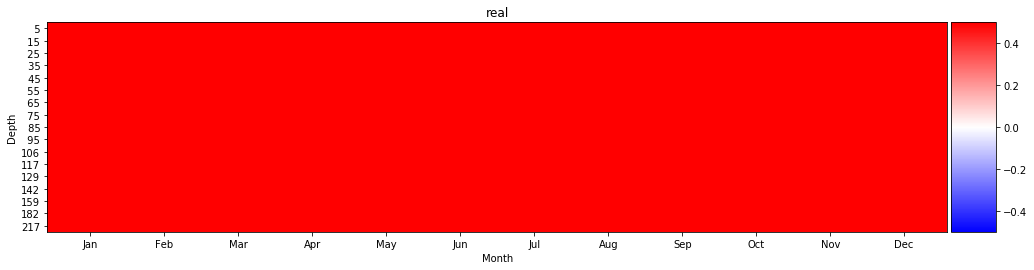

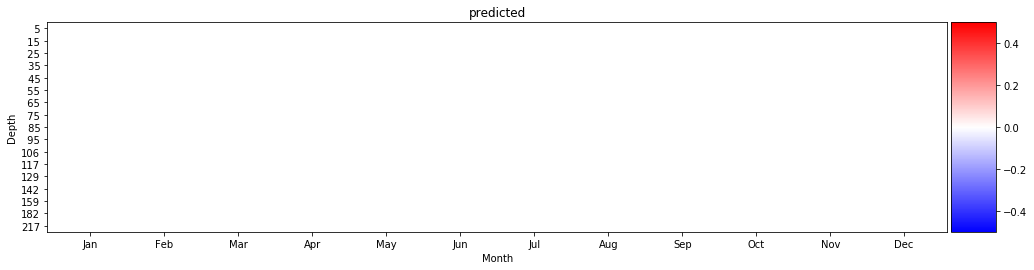

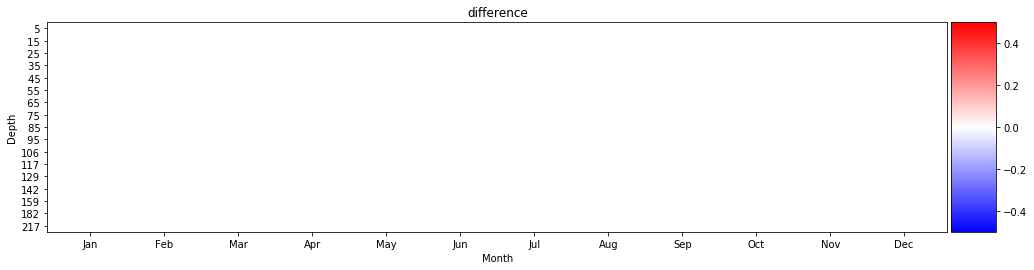

In [19]:
arch=(1000, 500, 500, 500, 1000, 2000)
model=generate(arch,['softplus']*len(arch))
        
mean=xtrains[0].mean()
std=xtrains[0].std()
        
xtrains[0]=(xtrains[0]-mean)/std
xtest=(xtest-mean)/std
        
        
#         yt=np.exp(yt*np.log(10))-eps
#         yv=np.exp(yv*np.log(10))-eps
        
        
model.fit(xtrains[0].values,ytrains[0].values,
          epochs=10000,
          callbacks=callbacks,
          verbose=0,
          batch_size=73*10, 
          validation_data=(xtest,ytest))
        
yp = model.predict(xtest)
        
#check error in original space
        
#yp=np.exp(yp*np.log(10))
#ytest=np.exp(ytest*np.log(10))    

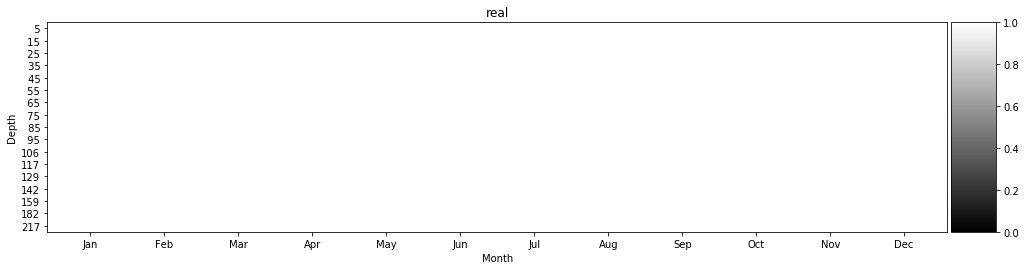

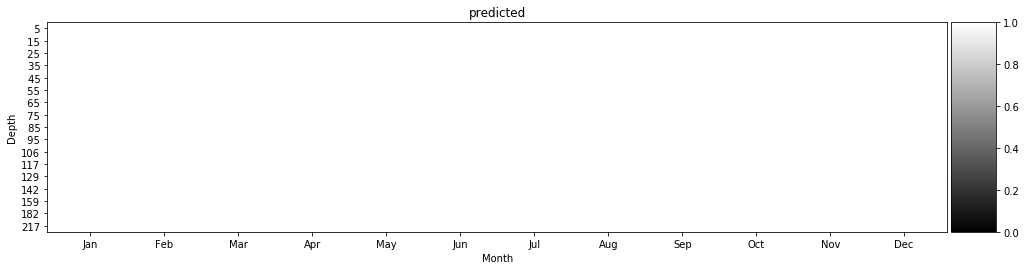

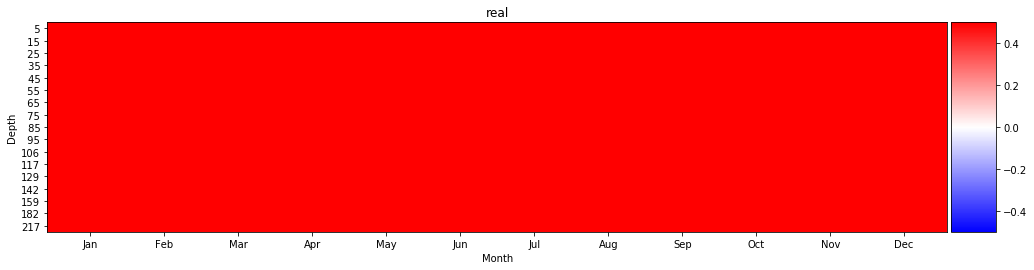

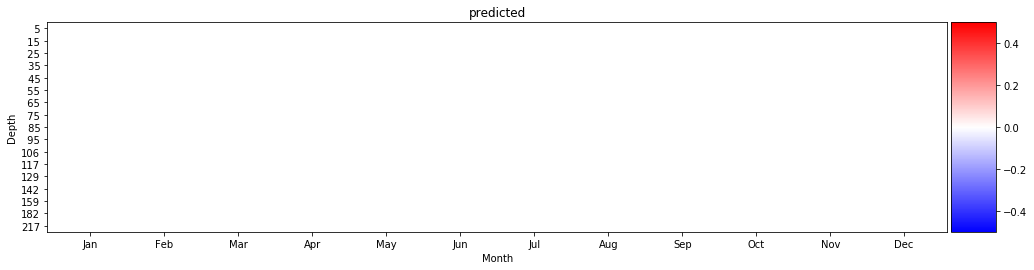

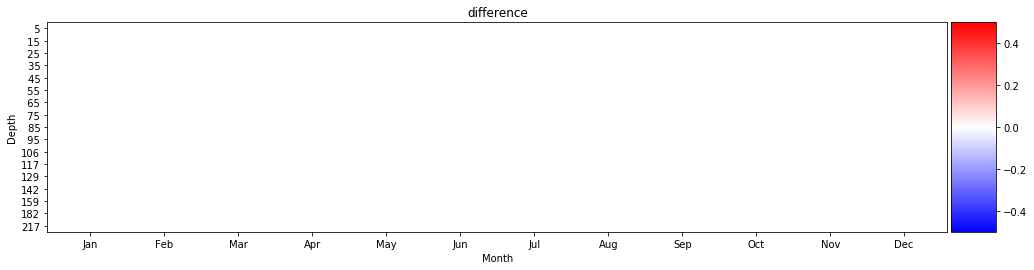

In [20]:
plotYear(ytest,title='real')
plotYear(yp,title='predicted')
climato(ytest, title='real')
climato(yp, title='predicted')
climato(ytest-yp, title='difference')

In [21]:
print(ytest)

[[32.92994377 32.92889704 32.92681407 ... 18.26064016 14.91879184
  12.10780403]
 [43.37258227 43.36942043 43.36383041 ... 18.03307708 14.90081716
  12.11896461]
 [43.7706324  43.76690886 43.76037063 ... 17.81476413 14.93684943
  12.15213623]
 ...
 [35.62556473 35.62378103 35.620569   ... 19.82316548 16.08013655
  12.21739709]
 [40.77628752 40.77328446 40.76798651 ... 19.47401224 16.11385357
  12.297558  ]
 [41.66525205 41.66223686 41.65695204 ... 19.00178945 16.09356677
  12.3505427 ]]
